# Twitter Sentiment Analysis

This notebook aims to analyze Tweets made about the COVID-19 vaccine and determine whether the sentiment of the Tweets is negative, positive, or neutral.

## Libraries

In [72]:
import tweepy
import webbrowser
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import config
pd.set_option('display.max_colwidth', None)

from tweepy import OAuthHandler
from tweepy import API

import os
from google.oauth2 import service_account
from google.cloud import translate_v2 as translate

import nltk
from nltk.corpus import gutenberg, stopwords
from nltk import FreqDist, word_tokenize
import string
import re

## Gather data from Twitter API

In [2]:
# Developer API keys
# API keys in config.py in .gitignore
callback_uri = 'oob'

In [3]:
auth = OAuthHandler(config.consumer_key, config.consumer_secret, callback_uri)
auth.set_access_token(config.access_token, config.access_token_secret)

In [4]:
api = API(auth, wait_on_rate_limit= True, wait_on_rate_limit_notify= True)

In [5]:
# show my Twitter handle
me = api.me()
print(me.screen_name)

cassienutter1


In [6]:
# simple query to get the hang of it
query = '#vaccine covid'
for i, status in enumerate(tweepy.Cursor(api.search, q= query).items(50)):
    print (i, status.text)

# filter only English tweets    
# query = '#vaccine covid'
# for i, status in enumerate(tweepy.Cursor(api.search, q= query, lang= 'en').items(50)):
#     print (i, status.text)

0 RT @TOKATODAY: The U.K. has recorded its lowest Covid death rate in six months this week as the vaccine rollout continues to advance.

#COV…
1 Kenya stops the private importation of COVID-19 vaccines https://t.co/GcVsD2dH4P  #TodaysMedicalUpdate #Medicine… https://t.co/lU1IFACsBD
2 I once read a paper where it showed how Covid is a vascular disease and contributes to blood clotting. People with… https://t.co/0TjQyd4bva
3 RT @Redpainter1: I fully support your right to not get the COVID vaccine.

I also fully support businesses, schools, sporting events, movie…
4 2 free webinars next week on0" COVID-19 Vaccination and Reaching People with Disabilities" by the Association of Un… https://t.co/zhyYOksyx3
5 👏 Well done, Google.

"While there’s still uncertainty ahead, the #vaccine gives us the reason for hope. As the vac… https://t.co/c2aUTHBIpW
6 Well, good luck if doctors can spot something so rare and complicated prior to issuing the jab. Better to go for a… https://t.co/2qtNtuYAkD
7 15

In [7]:
''' This cell was run to collect the initial 5000 tweets and save them to a csv file
is commented out to prevent it from being run again


# collect 5000 tweets 
number_of_tweets = 5000
tweets = []
language = []
time = []

# only collect full text, language, and time it was posted
# remove any retweets '-RT'
for i in tweepy.Cursor(api.search, q= 'vaccine covid -RT',  
                       tweet_mode = 'extended').items(number_of_tweets):
    tweets.append(i.full_text)
    language.append(i.lang)
    time.append(i.created_at)

# turn tweets / lists into dataframe
df = pd.DataFrame({'time': time, 'language': language, 'tweets': tweets})

# save df to csv
df.to_csv('data/tweets.csv', index= False)
'''

" This cell was run to collect the initial 5000 tweets and save them to a csv file\nis commented out to prevent it from being run again\n\n\n# collect 5000 tweets \nnumber_of_tweets = 5000\ntweets = []\nlanguage = []\ntime = []\n\n# only collect full text, language, and time it was posted\n# remove any retweets '-RT'\nfor i in tweepy.Cursor(api.search, q= 'vaccine covid -RT',  \n                       tweet_mode = 'extended').items(number_of_tweets):\n    tweets.append(i.full_text)\n    language.append(i.lang)\n    time.append(i.created_at)\n\n# turn tweets / lists into dataframe\ndf = pd.DataFrame({'time': time, 'language': language, 'tweets': tweets})\n\n# save df to csv\ndf.to_csv('data/tweets.csv', index= False)\n"

Collect more tweets after waiting to avoid collecting the same tweets.

In [8]:
# create function to get more tweets and add to existing csv
def get_more_tweets(num_tweets):
    number_of_tweets = num_tweets
    tweets = []
    language = []
    time = []

    # only collect full text, language, and time it was posted
    # remove any retweets '-RT'
    for i in tweepy.Cursor(api.search, q= 'vaccine covid -RT',  
                           tweet_mode = 'extended').items(number_of_tweets):
        tweets.append(i.full_text)
        language.append(i.lang)
        time.append(i.created_at)
        
    # turn tweets / lists into dataframe
    df = pd.DataFrame({'time': time, 'language': language, 'tweets': tweets})
    
    # add to existing csv file
    df.to_csv('data/tweets.csv', mode= 'a', index= False, header= False)

In [9]:
get_more_tweets(50)

### Search for Tweets from 30 Days Ago

In [10]:
# function to turn results into DataFrame
def extract_text_as_df(text_list):
    columns = set()
    allowed_types = [str, int]
    tweets_data = []
    for status in text_list:
        status_dict = dict(vars(status))
        keys = status_dict.keys()
        single_tweet_data = {"author": status.author.screen_name}
        for k in keys:
            try:
                v_type = type(status_dict[k])
            except:
                v_type = None
            if v_type != None:
                if v_type in allowed_types:
                    single_tweet_data[k] = status_dict[k]
                    columns.add(k)
        tweets_data.append(single_tweet_data)


    header_cols = list(columns)
    header_cols.append('author')
    df = pd.DataFrame(tweets_data, columns=header_cols)
    return df

In [11]:
query = 'vaccine covid -RT'
results_30 = api.search_30_day('datacollection', query, maxResults= 100)

In [12]:
old_results_df = extract_text_as_df(results_30)

In [13]:
old_results_df

,filter_level,id,favorite_count,in_reply_to_status_id,reply_count,id_str,quoted_status_id_str,in_reply_to_user_id_str,retweet_count,in_reply_to_user_id,source_url,in_reply_to_screen_name,lang,quote_count,in_reply_to_status_id_str,quoted_status_id,source,text,author
0,low,1378468859976552448,0,NaN,0,1378468859976552448,NaN,NaN,0,NaN,http://www.socialflow.com,NaN,en,0,NaN,NaN,SocialFlow,"Since people have three vaccine options to choose from for protection against COVID-19, they may be wondering which… https://t.co/JFBMjm3lhI",KLFY
1,low,1378468843438403584,0,NaN,0,1378468843438403584,NaN,NaN,0,NaN,https://mobile.twitter.com,NaN,en,0,NaN,NaN,Twitter Web App,Pharmacies score customer data in vaccine effort. Some are crying foul. https://t.co/rNbfk1w92h via @politico,AllOnMedicare
2,low,1378468843266445318,0,NaN,0,1378468843266445318,NaN,NaN,0,NaN,NaN,NaN,en,0,NaN,NaN,,"New availability: Centura\nColorado State Fairgrounds (Pfizer Vaccine): 1001 Beulah Ave, Pueblo, CO 81004\nAccess her… https://t.co/uwcNRLUDP4",COVaxAlerts
3,low,1378468842255618052,0,NaN,0,1378468842255618052,NaN,NaN,0,NaN,NaN,NaN,en,0,NaN,NaN,,"New availability: Centura\nDicks Sporting Goods Park Lot H (J&amp;J Vaccine): 6000 Victory Way, Commerce City, CO 80022… https://t.co/4A7uU4Zwse",COVaxAlerts
4,low,1378468802753617929,0,1.378468e+18,0,1378468802753617929,NaN,622969430,0,6.229694e+08,http://twitter.com/download/android,BlackIrishI,en,0,1378467871328624641,NaN,Twitter for Android,@BlackIrishI @PotatoSmug @my4loves5 I haven't had covid and will not be taking the vaccine.,bozena_kania
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,low,1378468017638608904,1,1.378468e+18,1,1378468017638608904,NaN,35825117,0,3.582512e+07,http://twitter.com/download/android,gauchoeddy,en,0,1378467789325824003,NaN,Twitter for Android,@gauchoeddy @bougatsas1 @TheBlueMatt Exactly my reaction to anyone who wants a covid vaccine.,RickV3D
96,low,1378467994075074564,0,NaN,0,1378467994075074564,1378320862588329987,NaN,0,NaN,http://twitter.com/#!/download/ipad,NaN,en,0,NaN,1.378321e+18,Twitter for iPad,Talking to a friend and he reminded me about the time when Blair wanted to introduce ID cards!\nNow Blair is telling… https://t.co/pqxOz4ZxlE,PatriciaDiane5
97,low,1378467964333264900,0,NaN,0,1378467964333264900,NaN,NaN,0,NaN,http://twitter.com/download/android,NaN,en,0,NaN,NaN,Twitter for Android,1. No - not a ducking chance.\n2. I'm not using the NHS app as it doesn't work properly -ive seen 1st hand.\n3. I ha… https://t.co/OgYim0rA1Q,Running_Far
98,low,1378467963699933186,0,1.378316e+18,0,1378467963699933186,NaN,10215212,0,1.021521e+07,https://mobile.twitter.com,NHSuk,en,0,1378316438906269697,NaN,Twitter Web App,@NHSuk This article says otherwise. The mainstream media and bodies like the NHS are under-reporting Covid-19 vacci… https://t.co/mp46cwSgAn,MarkJudeGlover2


## Data Cleaning & EDA

In [14]:
df = pd.read_csv('data/tweets.csv')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17450 entries, 0 to 17449
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   time      17450 non-null  object
 1   language  17450 non-null  object
 2   tweets    17450 non-null  object
dtypes: object(3)
memory usage: 409.1+ KB


### Check and Remove Duplicates

In [16]:
# check for duplicated tweets
duped = df[df.duplicated(subset= 'tweets')]
duped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 812 to 16476
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   time      39 non-null     object
 1   language  39 non-null     object
 2   tweets    39 non-null     object
dtypes: object(3)
memory usage: 1.2+ KB


In [17]:
# remove duplicates
df.drop_duplicates(subset= 'tweets', keep= 'first', inplace= True)
df.reset_index(drop= True, inplace= True)

# make sure they are gone
df.tweets.duplicated().sum()

0

### Looking at Languages

In [18]:
lang_df = df.sort_values('language')

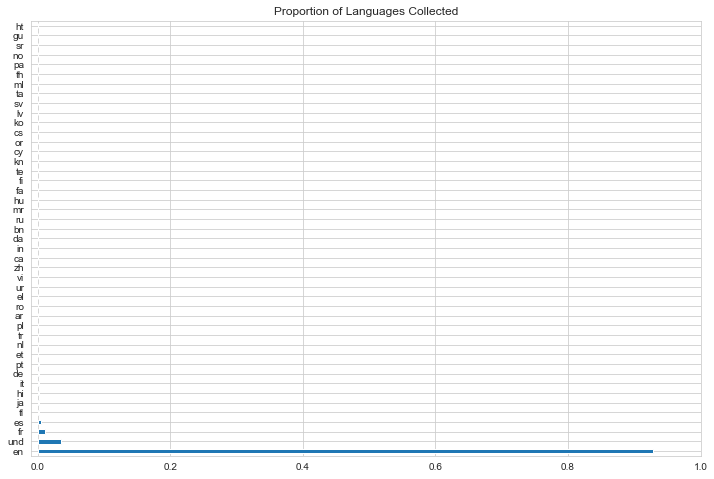

In [19]:
plt.figure(figsize= (12, 8))
lang_df.language.value_counts(normalize=True).plot(kind= 'barh')
plt.title('Proportion of Languages Collected')
plt.xlim(-.01, 1)
plt.show()

In [20]:
lang_df.language.value_counts(normalize=True)

en     0.927977
und    0.035495
fr     0.011430
es     0.004480
tl     0.002297
ja     0.001953
hi     0.001608
it     0.001436
de     0.001321
pt     0.001264
et     0.000976
nl     0.000862
tr     0.000747
pl     0.000747
ar     0.000632
ro     0.000517
el     0.000517
ur     0.000459
vi     0.000459
zh     0.000402
ca     0.000402
in     0.000345
da     0.000345
bn     0.000287
ru     0.000230
mr     0.000230
hu     0.000230
fa     0.000230
fi     0.000230
te     0.000172
kn     0.000172
cy     0.000172
or     0.000172
cs     0.000172
ko     0.000115
lv     0.000115
sv     0.000115
ta     0.000115
ml     0.000115
th     0.000115
pa     0.000115
no     0.000057
sr     0.000057
gu     0.000057
ht     0.000057
Name: language, dtype: float64

In [21]:
# what are these languages? get table from url
URL = 'https://developer.twitter.com/en/docs/twitter-for-websites/supported-languages'
tables = pd.read_html(URL)
print("There are : ",len(tables)," tables")
print(tables[0])

lang_table = tables[0]

There are :  1  tables
                        0              1
0                    Name  Language code
1       English (default)             en
2                  Arabic             ar
3                 Bengali             bn
4                   Czech             cs
5                  Danish             da
6                  German             de
7                   Greek             el
8                 Spanish             es
9                 Persian             fa
10                Finnish             fi
11               Filipino            fil
12                 French             fr
13                 Hebrew             he
14                  Hindi             hi
15              Hungarian             hu
16             Indonesian             id
17                Italian             it
18               Japanese             ja
19                 Korean             ko
20                  Malay            msa
21                  Dutch             nl
22              Norwegian         

In [22]:
# format table
header_row = 0
lang_table.columns = lang_table.iloc[header_row]
lang_table = lang_table.drop(header_row)
lang_table.reset_index(drop= True, inplace= True)

lang_table.replace('English (default)', 'English', inplace= True)
# lang_table

In [23]:
# save as csv in data folder
lang_table.to_csv('data/languages.csv', index= False)

In [24]:
# look at 'und' language 
df[df['language'] == 'und']

,time,language,tweets
1,2021-04-01 21:58:44,und,@and_kell @ds13_manon https://t.co/sKnTctMKcF
19,2021-04-01 21:58:14,und,https://t.co/j2braq4wFx
29,2021-04-01 21:57:58,und,@Pavlos80322302 @ds13_manon https://t.co/sKnTctMKcF
79,2021-04-01 21:56:21,und,👍🏼👍🏼👍🏼👍🏼 https://t.co/m68KkEqpOe
97,2021-04-01 21:55:44,und,https://t.co/Stomi0I13k
...,...,...,...
17163,2021-04-03 20:34:00,und,@DuncH39862069 https://t.co/yFjpUBMTEk
17167,2021-04-03 20:33:42,und,https://t.co/IDsdhJE4EJ
17182,2021-04-03 20:33:19,und,@JayantBhandari5 https://t.co/OT2LAibkFF
17324,2021-04-03 20:27:36,und,https://t.co/rksYeOs5y3


It appears that the 'und' or possibly 'undetermined' language are tweets that do not include text to help us with our sentiment analysis. We will remove those from our DataFrame.

In [25]:
df = df[df['language'] != 'und']
# df.info()

Merge the data with the languages to see the whole name of languages

In [26]:
# merge data with language names
df2 = df.merge(lang_table, how= 'inner', left_on= 'language', right_on= 'Language code')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16689 entries, 0 to 16688
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   time           16689 non-null  object
 1   language       16689 non-null  object
 2   tweets         16689 non-null  object
 3   Name           16689 non-null  object
 4   Language code  16689 non-null  object
dtypes: object(5)
memory usage: 782.3+ KB


In [27]:
# drop extra columns and rename them and change dates to datetime and drop time
df2.drop(columns = ['language', 'Language code'], inplace= True)
df2.rename(columns={'Name': 'language'}, inplace= True)
df2['time'] = pd.to_datetime(df2['time']).dt.date
# df2

Let's see how many Tweets are in each language?

<AxesSubplot:xlabel='count', ylabel='language'>

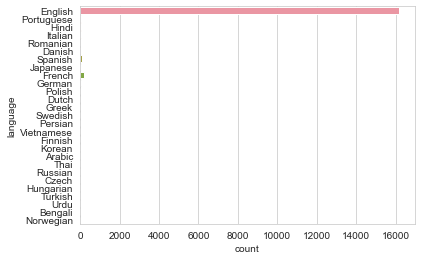

In [28]:
sns.countplot(y= 'language', data= df2)

The majority of Tweets are in English. Let's see what the other languages are.

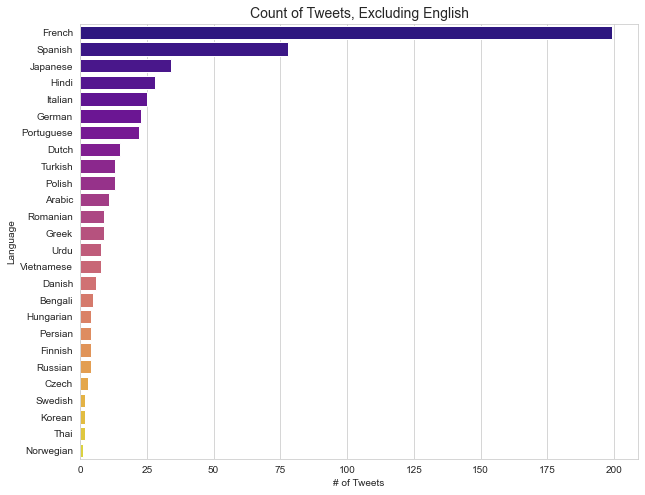

In [29]:
# countplot that excludes English to see detail
plt.figure(figsize= (10, 8))
sns.countplot(y= 'language', data= df2, palette='plasma',
              order= df2.language.value_counts().iloc[1:].index)
plt.title('Count of Tweets, Excluding English', fontsize= 14)
plt.xlabel('# of Tweets')
plt.ylabel('Language')
plt.show()

After English, the top 3 languages for Tweets about the COVID-19 vaccine are in French, Spanish, and Japanese.

#### Translate to English using Google Cloud Platform's API

In [30]:
# send in credentials that are saved on local computer
credentials = service_account.Credentials.from_service_account_file('../GCP_service_account.json')
translate_client = translate.Client(credentials= credentials)

In [31]:
# see all languages that Google can translate
print(translate_client.get_languages())

[{'language': 'af', 'name': 'Afrikaans'}, {'language': 'sq', 'name': 'Albanian'}, {'language': 'am', 'name': 'Amharic'}, {'language': 'ar', 'name': 'Arabic'}, {'language': 'hy', 'name': 'Armenian'}, {'language': 'az', 'name': 'Azerbaijani'}, {'language': 'eu', 'name': 'Basque'}, {'language': 'be', 'name': 'Belarusian'}, {'language': 'bn', 'name': 'Bengali'}, {'language': 'bs', 'name': 'Bosnian'}, {'language': 'bg', 'name': 'Bulgarian'}, {'language': 'ca', 'name': 'Catalan'}, {'language': 'ceb', 'name': 'Cebuano'}, {'language': 'ny', 'name': 'Chichewa'}, {'language': 'zh-CN', 'name': 'Chinese (Simplified)'}, {'language': 'zh-TW', 'name': 'Chinese (Traditional)'}, {'language': 'co', 'name': 'Corsican'}, {'language': 'hr', 'name': 'Croatian'}, {'language': 'cs', 'name': 'Czech'}, {'language': 'da', 'name': 'Danish'}, {'language': 'nl', 'name': 'Dutch'}, {'language': 'en', 'name': 'English'}, {'language': 'eo', 'name': 'Esperanto'}, {'language': 'et', 'name': 'Estonian'}, {'language': 'tl'

In [62]:
# separate non-English tweets for faster translating
part_df = df2.loc[16100:]
# part_df.language.value_counts(normalize= True)

In [68]:
# create dictionary to save original tweet and translated one
results = {}

# translate tweets into English
for i in part_df.tweets.loc[:]:
    result = translate_client.translate(i, target_language= 'en')
    results[i] = result['translatedText']

In [69]:
# replace with English translation
df2.tweets.replace(results, inplace= True)

In [70]:
# preview previously French Tweets
df2[df2['language'] == 'French']

,time,tweets,language
16359,2021-04-01,"@ BenoitG70293865 @francoislegault Haha! This guy is my spiritual animal 🤣 No, but do you have to be thick to ask a vaccinated guy if he&#39;s afraid of the Covid?",French
16360,2021-04-01,"So my father, who has been fighting multiple sclerosis for over 10 years now, must be vaccinated against covid on the pretext that he is a person at risk ?? A PERSON AT RISK ???? It&#39;s not like he got this damn disease from a FUCKING VACCINE !!",French
16361,2021-04-01,"@ Latnaille77 They are quite right! Had he had a serological check before his vaccination! Perhaps he had already had an asymptomatic form of covid and was immune. We do not vaccinate in this case. But hey, since everything is done in spite of common sense, how many victims to deplore 😪",French
16362,2021-04-01,@ Digitalchaos8 @ Poulin2012 My neighbor duly vaccinated in the 1st serious Covid ...,French
16363,2021-04-01,Gold D Roger is said to have actually died after being vaccinated against Covid-19. https://t.co/OvoulfUryJ,French
...,...,...,...
16553,2021-04-03,"Vaccinated, the Argentine president tested positive for Covid-19 - Le Point https://t.co/hMiSG4V2BY via @LePoint",French
16554,2021-04-03,"The Argentine president, although vaccinated, tested positive for Covid-19 https://t.co/LlrUizXVgT https://t.co/JuccC3VnbP",French
16555,2021-04-03,"Covid - An 8-year-old child &quot;vaccinated&quot; by mistake Dallas County obliges to register online to be bitten (with date of birth to be informed) The father believed it normal that his son be vaccinated, after receiving a QR code. VF right click https://t.co/8KkpHEr3Sr",French
16556,2021-04-03,They want us to get vaccinated so that doesn&#39;t prevent you from having the virus or being a carrier of the virus ... Its just decreases the severity if you have covid.,French


In [71]:
# save to csv file
df2.to_csv('data/tweets_translated.csv', index= False)

## Text Sentiment
---
Does the tweet have a positive, negative, or neutral tone?

### Feature Engineering for Text Data
--- 
stopword removal
frequency distributions
lemmatization
bigramsm n-grams, and mutal information score

In [79]:
sentiment_df = df2[['time', 'tweets']]

In [81]:
sentiment_df.head()

,time,tweets
0,2021-04-01,"Concerning the use of aborted baby tissue in the J&amp;J Covid vaccine:\n\n“The J&amp;J vaccine has sparked debate among some religious communities because it was developed from stem cells obtained during two abortions decades ago.”\n\nEvil is still evil, even if it was decades ago."
1,2021-04-01,imagine an animal getting the covid-19 vaccine b4 a human
2,2021-04-01,Definition of a microstate: https://t.co/8N0R8Mhl73\n\nSource of vaccine data: https://t.co/0RQFJPTrZZ
3,2021-04-01,"If I’ve Had COVID-19, Do I Still Need Two Doses of Vaccine? https://t.co/08AiBgfEHQ"
4,2021-04-01,"My epidural was delayed again, somehow my covid vaccine does not interact well with an epidural. SOOOOO I should be getting it on my birthday. Yay. \n\n So far I have 1-2 dr appointments a week this entire month.\n \nOn the upside they've given me proper muscle relaxers this time."


In [82]:
# convert text to lowercase and remove stopwords
def process_tweets(tweet):
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed

In [84]:
# import nltk
# nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/cassienutter/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [85]:
sentiment_df = sentiment_df.apply(lambda x: process_tweets(x) if x.name == 'tweets' else x)

TypeError: expected string or bytes-like object

In [ ]:
# remove punctuation

In [ ]:
# tokenization

In [ ]:
# lemmatization

In [ ]:
# Part of speech (POS) tagging